In [2]:
import numpy as np
import multiprocessing
from sko.GA import GA
from sko.PSO import PSO
from sko.DE import DE
import matplotlib.pyplot as plt
import random
import math
import random
from copy import deepcopy
from math import sin, cos, log
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
de_nodes = []
ga_nodes = []
pso_nodes = []

def P_min(f):
    other_mins = []
    de = DE(func=f, n_dim=DIM, lb=LB, ub=UB, max_iter=ITER // 2, size_pop=POP)
    ga = GA(func=f, n_dim=DIM, lb=LB, ub=UB, max_iter=ITER, size_pop=POP, precision=1e-200)
    pso = PSO(func=f, dim=DIM, pop=POP, max_iter=ITER, lb=LB, ub=UB)
    _, e_de = de.run()
    e_de = e_de[0]
    _, e_ga = ga.run()
    e_ga = e_ga[0]
    pso.run()
    e_pso = pso.gbest_y
    time_de, time_ga, time_pso = 0, 0, 0
    cnt = 0
    while True:
        de_x, temp_de = de.run()
        temp_de = temp_de[0]
        time_de = time_de + 1 if e_de - temp_de < CALC_PRECISION else 0
        e_de = temp_de
        ga_x, temp_ga = ga.run()
        temp_ga = temp_ga[0]
        time_ga = time_ga + 1 if e_ga - temp_ga < CALC_PRECISION else 0
        e_ga = temp_ga
        pso.run()
        time_pso = time_pso + 1 if e_pso - pso.gbest_y < CALC_PRECISION else 0
        e_pso = pso.gbest_y
        res = sorted([[e_de, time_de, de_x], [e_ga, time_ga, ga_x], [e_pso, time_pso, pso.gbest_x]], key = lambda x:x[0])
        if res[1][0] - res[0][0] < CALC_PRECISION and res[0][1] > STOP_ITER_TIME:
            return (res[0][0],res[0][2])
        if res[0][1] > STOP_ITER_TIME and res[1][1] > STOP_ITER_TIME and res[2][1] > STOP_ITER_TIME:
            other_mins.append((res[0][0],res[0][2]))
            if len(other_mins) == 10:
                return min(other_mins, key = lambda x:x[0])
            res = []
            de = DE(func=f, n_dim=DIM, lb=LB, ub=UB, max_iter=ITER // 2, size_pop=POP)
            ga = GA(func=f, n_dim=DIM, lb=LB, ub=UB, max_iter=ITER, size_pop=POP, precision=1e-200)
            pso = PSO(func=f, dim=DIM, pop=POP, max_iter=ITER, lb=LB, ub=UB)
            de_x, e_de = de.run()
            e_de = e_de[0]
            ga_x, e_ga = ga.run()
            e_ga = e_ga[0]
            pso.run()
            e_pso = pso.gbest_y
            time_de, time_ga, time_pso = 0, 0, 0


def reg_time(args):
    kind, f, p_min = args
    print(".", end="")
    res_ary = [1e+500]
    if kind == "de":
        de = DE(func=f, n_dim=DIM, lb=LB, ub=UB, max_iter=1, size_pop=POP)
        time_de = 0
        while res_ary[-1] > p_min + MIN_PRECISION:
            if len(res_ary)>STOP_ITER_TIME//2 and res_ary[-STOP_ITER_TIME//2]-res_ary[-1] < CALC_PRECISION:
                de_nodes.pop(STOP_ITER_TIME//2)
                print("de",list(res_ary))
                return (False, (time_de-STOP_ITER_TIME//2)*2)
            _, temp_de = de.run()
            res_ary.append(temp_de[0])
            de_nodes.append(de.X)
            res_ary.append(temp_de[0])
            de_nodes.append(de.X)
            time_de += 1
        print("de",list(res_ary))
        return (True, time_de*2)
    if kind == "ga":
        ga = GA(func=f, n_dim=DIM, lb=LB, ub=UB, max_iter=1, size_pop=POP, precision=1e-200)
        time_ga = 0
        while res_ary[-1] > p_min+MIN_PRECISION:
            if len(res_ary)>STOP_ITER_TIME and res_ary[-STOP_ITER_TIME]-res_ary[-1] < CALC_PRECISION:
                ga_nodes.pop(STOP_ITER_TIME)
                print("ga",list(res_ary))
                return (False, time_ga-STOP_ITER_TIME)
            _, temp_ga = ga.run()
            res_ary.append(temp_ga[0])
            ga_nodes.append(ga.X)
            time_ga += 1
        print("ga",list(res_ary))
        return (True, time_ga)
    if kind == "pso":
        pso = PSO(func=f, dim=DIM, pop=POP, max_iter=1, lb=LB, ub=UB)
        time_pso = 0
        while res_ary[-1] > p_min+MIN_PRECISION:
            if len(res_ary)>STOP_ITER_TIME and res_ary[-STOP_ITER_TIME]-res_ary[-1] < CALC_PRECISION:
                pso_nodes.pop(STOP_ITER_TIME)
                print("pso",list(res_ary))
                return (False, time_pso-STOP_ITER_TIME)
            pso.run()
            res_ary.append(pso.gbest_y)
            pso_nodes.append(pso.X)
            time_pso += 1
        print("pso",list(res_ary))
        return (True, time_pso)
def evaluate(f):
    p_min, p_min_x = P_min(f)
    print(p_min,list(p_min_x))
    for i in range(DIM):
        if (MIN_PRECISION - 1 < p_min_x[i] < 1 - MIN_PRECISION):
            break
    else:
        return 1e7
    if f([1 for _ in range(DIM)]) - p_min < CALC_PRECISION:
        return 1e7
    all_cnt = 0
    right_cnt = 0
    times = 0
    while True:
        s = map(reg_time, [("de", f, p_min)] * TEST_TIME)
        for i in s:
            if i[0]:
                right_cnt += 1
            times += i[1]
            all_cnt+=1
            if TEST_TIME <= right_cnt or MAX_TEST_TIME <= all_cnt:
                break
        if TEST_TIME <= right_cnt or MAX_TEST_TIME <= all_cnt:
            break
    de_score = times/all_cnt/(right_cnt/all_cnt+ MIN_TEST_ACC)
    print("。",de_score)
    all_cnt = 0
    right_cnt = 0
    times = 0
    while True:
        s = map(reg_time, [("ga", f, p_min)] * TEST_TIME)
        for i in s:
            if i[0]:
                right_cnt += 1
            times += i[1]
            all_cnt+=1
            if TEST_TIME <= right_cnt or MAX_TEST_TIME <= all_cnt:
                break
        if TEST_TIME <= right_cnt or MAX_TEST_TIME <= all_cnt:
            break
    ga_score = times/all_cnt/(right_cnt/all_cnt+ MIN_TEST_ACC)
    print("。")
    all_cnt = 0
    right_cnt = 0
    times = 0
    while True:
        s = map(reg_time, [("pso", f, p_min)] * TEST_TIME)
        for i in s:
            if i[0]:
                right_cnt += 1
            times += i[1]
            all_cnt+=1
            if TEST_TIME <= right_cnt or MAX_TEST_TIME <= all_cnt:
                break
        if TEST_TIME <= right_cnt or MAX_TEST_TIME <= all_cnt:
            break
    pso_score = times/all_cnt/(right_cnt/all_cnt+ MIN_TEST_ACC)
    print("。")
    print("avg", de_score, ga_score, pso_score)
    print("score", de_score / pso_score if pso_score < ga_score else de_score / ga_score, ga_score / pso_score if pso_score < de_score else ga_score / de_score, pso_score / ga_score if ga_score < de_score else pso_score / de_score)
    return ga_score / pso_score if pso_score < de_score else ga_score / de_score

KIND_FUNC = 1
KIND_CONST = 2
KIND_VAR = 3
res_list, de_BE_cnt = [], 0
DIM = 2
ITER, POP, LB, UB, STOP_ITER_TIME, CALC_PRECISION, MIN_PRECISION, MAX_CALC_MEAN_TIME = 2, 50, [-1]*DIM, [1]*DIM, 400, 1e-11, 1e-10, 10
TEST_TIME, MAX_TEST_TIME, MIN_TEST_ACC = 1, 1, 0.005

if __name__ == '__main__':
#    func_str = "sin(log(abs((var[1]+sin(var[0])))+1))"
    func_str = "(log(abs(sin(log(abs((var[0]+var[1]))+1)))+1)+sin(sin(var[0])))"
#    func_str = "sin((cos((0.23171727502870929))+cos((var[0]+cos(sin((sin(var[1])*var[1])))))))"
    ff = eval(f"lambda var:{func_str}")
    for i in range(DIM):
        v1 = [1 if j ==i else 0 for j in range(DIM)]
        v2 = [-1 if j ==i else 0 for j in range(DIM)]
        func_str+=f"-({(ff(v1)-ff(v2))/2}*var[{i}])"
    print(func_str)
    ff = eval(f"lambda var:{func_str}")
    i = evaluate(ff)

(log(abs(sin(log(abs((var[0]+var[1]))+1)))+1)+sin(sin(var[0])))-(0.7456241416655579*var[0])-(0.0*var[1])
-0.08914657509301116 [-0.5414793887974161, 0.541479388797416]
.de [inf, -0.011224061860465206, -0.011224061860465206, -0.011224061860465206, -0.011224061860465206, -0.011224061860465206, -0.011224061860465206, -0.08072402296747905, -0.08072402296747905, -0.08072402296747905, -0.08072402296747905, -0.08072402296747905, -0.08072402296747905, -0.08072402296747905, -0.08072402296747905, -0.08072402296747905, -0.08072402296747905, -0.08072402296747905, -0.08072402296747905, -0.08072402296747905, -0.08072402296747905, -0.08072402296747905, -0.08072402296747905, -0.08072402296747905, -0.08072402296747905, -0.08072402296747905, -0.08072402296747905, -0.08072402296747905, -0.08072402296747905, -0.08072402296747905, -0.08072402296747905, -0.08072402296747905, -0.08072402296747905, -0.08072402296747905, -0.08072402296747905, -0.08072402296747905, -0.08072402296747905, -0.08072402296747905, -0.

.ga [inf, -0.021590904992315307, -0.07934204055575789, -0.08096184582118315, -0.08096184582118315, -0.0809618459551848, -0.08115193047233626, -0.08115193047233626, -0.08115193047233626, -0.08115193047233626, -0.08115193047233626, -0.08115207708768568, -0.08115207708768568, -0.08115208716869343, -0.08115208716869343, -0.08115208716869343, -0.08115208786181549, -0.08115208786181549, -0.08115208786181549, -0.08115661313416822, -0.08115661313416822, -0.08115661313416822, -0.08115661313416822, -0.08115665120651333, -0.08115676983119785, -0.08115939394893712, -0.0811622533723636, -0.0811622533723636, -0.08116226507674568, -0.08116226507674568, -0.08116226507674568, -0.08116234679412249, -0.08116234679422069, -0.08116238825890937, -0.0811625035021491, -0.0811625035021491, -0.0811632930025547, -0.0811632930025547, -0.0811632930025547, -0.0811632930025547, -0.0811632930025547, -0.0811632930025547, -0.0811632930025547, -0.0811638687122147, -0.0811638687122147, -0.0811638687122147, -0.08116386871

pso:0.6-1.1
de:-0.1-1.1
ga:0,1

In [49]:
ff([-1,0])

0.724421526600871

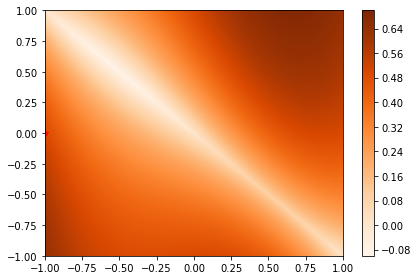

In [37]:
import matplotlib.pyplot as plt
fig = plt.figure(tight_layout=True)
x=np.linspace(-1,1,101)
y=np.linspace(-1,1,101)
X,Y=np.meshgrid(x,y)
Z = [[ff([i,j]) for i in x] for j in y]
lim=np.arange(-0.1,0.7,0.001)
plt.contourf(X,Y,Z,lim,cmap="Oranges")
plt.plot(-1,0,"r*")
plt.colorbar()

In [25]:
?plt.plot

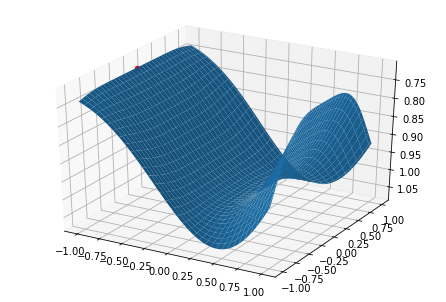

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import MultipleLocator,FuncFormatter
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(X, Y, -np.array(Z))
ax.zaxis.set_major_formatter(FuncFormatter(lambda i,ii:'%1.2f'%(-i+0.00001)))
ax.scatter(-1,0, -ff([-1,0]),c="r")
plt.show()

In [30]:
?ax.plot

In [4]:
ga_nodes[-1]

array([[-9.99999998e-01, -7.09561337e-04],
       [-9.99999998e-01, -7.09561337e-04],
       [-9.99999998e-01, -7.24764835e-04],
       [-9.99999998e-01, -7.09561336e-04],
       [-9.99999998e-01, -7.09561337e-04],
       [-9.99999998e-01, -7.09561337e-04],
       [-9.99999998e-01, -7.09561337e-04],
       [-9.99999998e-01, -7.09561337e-04],
       [-9.99999998e-01, -7.09561337e-04],
       [-9.99999987e-01, -7.09561337e-04],
       [-9.99999998e-01, -7.09561337e-04],
       [-9.99999998e-01, -7.09561337e-04],
       [-9.99999998e-01, -7.09561337e-04],
       [-9.92187502e-01, -7.09561337e-04],
       [-9.99999998e-01, -7.09561337e-04],
       [-9.99999998e-01, -7.09561337e-04],
       [-9.99999998e-01, -7.24764835e-04],
       [-9.99999972e-01, -7.09561337e-04],
       [-9.99999998e-01, -7.24764835e-04],
       [-9.99999998e-01, -7.09561227e-04],
       [-9.99999998e-01, -7.09561337e-04],
       [-9.99999998e-01, -7.09561337e-04],
       [-9.99999998e-01, -7.09561337e-04],
       [-9.

In [28]:
ff([-0.25,0.25])

0.00259267394766258

MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


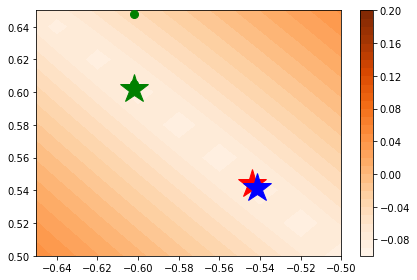

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
de_ani, ga_ani, pso_ani = [0 for _ in range(50)], [0 for _ in range(50)], [0 for _ in range(50)]
def update_points(num):
    de_best = min(list(range(50)),key = lambda i: ff(de_nodes[min(num,len(de_nodes)-1)][i]))
    if len(de_nodes) > num:
        for i in range(50):
            de_ani[i].set_data( *de_nodes[num][i])
            de_ani[i].set_marker("o")
            de_ani[i].set_markersize(8)
        de_ani[de_best].set_marker("*")
        de_ani[de_best].set_markersize(30)
    de_ani[de_best].set_zorder(50+num*3+num%3)
    ga_best = min(list(range(50)),key = lambda i: ff(ga_nodes[min(num,len(ga_nodes)-1)][i]))
    if len(ga_nodes) > num:
        for i in range(50):
            ga_ani[i].set_data( *ga_nodes[num][i])
            ga_ani[i].set_marker("o")
            ga_ani[i].set_markersize(8)
        ga_best = min(list(range(50)),key = lambda i: ff(ga_nodes[num][i]))
        ga_ani[ga_best].set_marker("*")
        ga_ani[ga_best].set_markersize(30)
    ga_ani[ga_best].set_zorder(50+num*3+(num+1)%3)
    pso_best = min(list(range(50)),key = lambda i: ff(pso_nodes[min(num,len(pso_nodes)-1)][i]))
    if len(pso_nodes) > num:
        for i in range(50):
            pso_ani[i].set_data(*pso_nodes[num][i])
            pso_ani[i].set_marker("o")
            pso_ani[i].set_markersize(8)
        pso_best = min(list(range(50)),key = lambda i: ff(pso_nodes[num][i]))
        pso_ani[pso_best].set_marker("*")
        pso_ani[pso_best].set_markersize(30)
    pso_ani[pso_best].set_zorder(50+num*3+(num+2)%3)
    return de_ani+ga_ani+pso_ani

fig = plt.figure(tight_layout=True)
plt.axis([-0.65,-0.5,0.5,0.65])#0.7312576328559923, -0.6678062631945819
x=np.linspace(-1,1,101)
y=np.linspace(-1,1,101)
X,Y=np.meshgrid(x,y)
Z = [[ff([i,j]) for i in x] for j in y]
lim=np.arange(-0.1,0.2,0.01)
plt.contourf(X,Y,Z,lim,cmap="Oranges")
plt.colorbar()
for i in range(50):
    de_ani[i], = plt.plot(de_nodes[0][i][0], de_nodes[0][i][1], "bo")
    ga_ani[i], = plt.plot(ga_nodes[0][i][0], ga_nodes[0][i][1], "go")
    pso_ani[i], = plt.plot(pso_nodes[0][i][0], pso_nodes[0][i][1], "ro")
ani = animation.FuncAnimation(fig, update_points, np.arange(0, max(len(de_nodes),len(ga_nodes),len(pso_nodes))), interval=100, blit=True)
ani.save('sin_test19.gif', fps=10)
plt.show()

MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


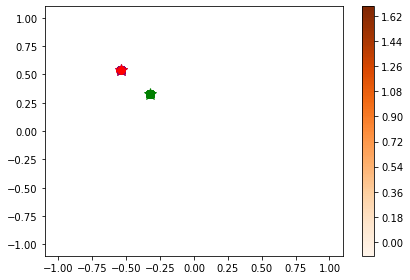

In [106]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
de_ani, ga_ani, pso_ani = [0 for _ in range(50)], [0 for _ in range(50)], [0 for _ in range(50)]
x=np.linspace(-0.545,-0.535,101)
y=np.linspace(0.535,0.545,101)
lim=np.arange(-0.1,1.7,0.01)
X,Y=np.meshgrid(x,y)
Z = [[ff([i,j]) for i in x] for j in y]
def update_points(num):
    for i in range(50):
        de_ani[i].set_data( *de_nodes[num][i])
        ga_ani[i].set_data( *ga_nodes[num][i])
        pso_ani[i].set_data(*pso_nodes[num][i])
        de_ani[i].set_marker("o")
        de_ani[i].set_markersize(8)
        ga_ani[i].set_marker("o")
        ga_ani[i].set_markersize(8)
        pso_ani[i].set_marker("o")
        pso_ani[i].set_markersize(8)
    de_best = min(list(range(50)),key = lambda i: ff(de_nodes[num][i]))
    de_ani[de_best].set_marker("*")
    de_ani[de_best].set_markersize(12)
    ga_best = min(list(range(50)),key = lambda i: ff(ga_nodes[num][i]))
    ga_ani[ga_best].set_marker("*")
    ga_ani[ga_best].set_markersize(12)
    pso_best = min(list(range(50)),key = lambda i: ff(pso_nodes[num][i]))
    pso_ani[pso_best].set_marker("*")
    pso_ani[pso_best].set_markersize(12)
    return de_ani+ga_ani+pso_ani
 
fig = plt.figure(tight_layout=True)
plt.contourf(X,Y,Z,lim,cmap="Oranges")
plt.colorbar()
for i in range(50):
    de_ani[i], = plt.plot(de_nodes[0][i][0], de_nodes[0][i][1], "bo")
    ga_ani[i], = plt.plot(ga_nodes[0][i][0], ga_nodes[0][i][1], "go")
    pso_ani[i], = plt.plot(pso_nodes[0][i][0], pso_nodes[0][i][1], "ro")
ani = animation.FuncAnimation(fig, update_points, np.arange(0, 486), interval=100, blit=True)
ani.save('sin_test3.gif', fps=10)
plt.show()

In [17]:
import numpy as np
import matplotlib.pyplot as plt
x=np.linspace(-3,3,101)
y=np.linspace(-3,3,101)
lim=np.arange(-2,2.1,0.1)
X,Y=np.meshgrid(x,y)
Z1=np.sin(X)*np.cos(Y)
print(Z1)

[[ 0.13970775  0.19822618  0.25603122 ... -0.25603122 -0.19822618
  -0.13970775]
 [ 0.13826218  0.19617511  0.25338203 ... -0.25338203 -0.19617511
  -0.13826218]
 [ 0.13631901  0.19341802  0.24982094 ... -0.24982094 -0.19341802
  -0.13631901]
 ...
 [ 0.13631901  0.19341802  0.24982094 ... -0.24982094 -0.19341802
  -0.13631901]
 [ 0.13826218  0.19617511  0.25338203 ... -0.25338203 -0.19617511
  -0.13826218]
 [ 0.13970775  0.19822618  0.25603122 ... -0.25603122 -0.19822618
  -0.13970775]]
